In [1]:
import tensorflow as tf
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import clear_output
import time
import numpy as np
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

## -- Creating the environment (=cartpole) and visualising the state:

-- State [position,velocity,angle,angular velocity] =  [ 0.03408987  0.01697779 -0.02238708  0.03005877]
-- Action space [move left, mmove right]=  Discrete(2)


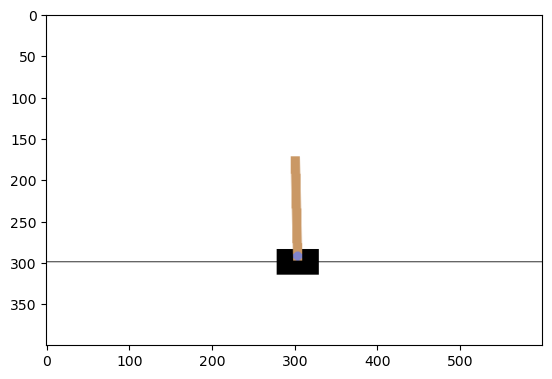

In [2]:
env = gym.make('CartPole-v1', render_mode="rgb_array")  #-- render_mode makes env.render() return a colormap.
env.reset()   #-- initialises the cartpole close to the origin with a slight random initial inclination and velocity. 
img = plt.imshow( env.render() )   #-- plot the state using 3D colormap plotting
print( '-- State [position,velocity,angle,angular velocity] = ',env.state )
print( '-- Action space [move left, mmove right]= ',env.action_space )

In [3]:
#-- let's make a video of one episode, where we randomly choose an action at each step.

filename = 'videos/randomly_chosen_actions'+'.mp4'
env.reset()
video = VideoRecorder(env,filename)
for i in range(100):
    env.render()
    video.capture_frame()
    action = env.action_space.sample()   #-- choose random action from the action space
    
    obs, reward, terminated, truncated, info = env.step( action )
    # env.step takes an action as argument and evolves env accrodingly. It outputs:
    #-- obs: the new state of the system
    #-- reward: the reward given by the new state
    #-- terminate: if the angle > ±12° or position > ±2.4
    #-- truncate: if episode length > 500
    
video.close()
env.close()

/Users/nicolas/miniconda3/lib/python3.8/site-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Moviepy - Building video videos/randomly_chosen_actions.mp4.
Moviepy - Writing video videos/randomly_chosen_actions.mp4



Moviepy - Done !
Moviepy - video ready videos/randomly_chosen_actions.mp4


## -- create the network and the agent classes

In [4]:
# This class that creates the neural net for the agent. 
# We choose a fully-connected net as is typical in reinfocement learing.
class Policy_Network(tf.keras.Model):
    
    def __init__(self, n_actions, fc):
        super(Policy_Network, self).__init__()

        self.fc1 = Dense(fc, activation='relu')
        self.fc2 = Dense(fc//2, activation='relu')
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)
        pi = self.pi(value)

        return pi

# -- The agent class invokes Policy_Network to create a neural net policy_network 
# that will generate a policr dependeing on the current state. 
# -- Also, It stores episodes generated by applying the policy_network and then can
# learn from the stored episodes using self.learn().
class Agent:
    
    def __init__(self, alpha=1e-3, n_actions=2, gamma=0.95, fc=20):
        self.gamma = gamma   #-- discount factor
        self.n_actions = n_actions    #-- size of the env.action_space
        self.state_memory = [] 
        self.action_memory = []
        self.reward_memory = []
        self.policy_network = Policy_Network( n_actions, fc )   #-- creating the network, or 'brain' of the agent
        self.policy_network.compile( optimizer=Adam(learning_rate=alpha) )  #-- compile the model

    def choose_action(self, state):
        state_tf = tf.convert_to_tensor([state])    #-- convert state to tf array
        policy = self.policy_network(state_tf)    #-- generate polisy using the network
        cumulative_distribution = np.cumsum( policy )   #-- generate random action accroding to policy
        p=np.random.uniform()
        for pick in range(self.n_actions):
            if p<cumulative_distribution[pick]:
                break
        return pick #-- pick is the chosen action
    
    def store_episode(self, observation, action, reward):
        #-- to be able to learn, the agent needs to record the action/state combinations, 
        #-- and what reward those have led to. [ observation = state ]
        self.state_memory.append(observation) 
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        
    def learn(self):

        batch_size = len( self.action_memory ) #-- number of episodes to learn from in one go

        G = [ [] for i in range(batch_size) ]  #-- return values, one for every step t of every batch i
        for i in range( batch_size ):
            N_steps = len( self.reward_memory[i] )  #-- number of steps in specific episode
            for t in range( N_steps ):
                G_sum = 0
                for k in range( N_steps-t ):
                    #-- at each step, add all rewards from future steps taken, but note:
                    #-- the further the step, the more discounted is the reward
                    G_sum += self.reward_memory[i][t+k] * self.gamma**k  
                G[i].append( tf.convert_to_tensor(G_sum) )
        
        #-- now comes GardientTape, which is used by tensorflow to keep track of all mathematical operations
        #-- used in calculating the loss function. It then uses these operations to perform backpropagation and 
        #-- calculate the gradients of every weight and bias (=self.policy_network.trainable_variables).
        with tf.GradientTape() as tape:
            loss=0.
            for i in range(batch_size):
                
                N_steps = len( self.reward_memory[i] )   #-- number of steps in specific episode
                states_tf = tf.convert_to_tensor(self.state_memory[i])  #-- converte state to tf array
                actions_tf = tf.convert_to_tensor(self.action_memory[i])  #-- converte actions to tf array
                probs = self.policy_network(states_tf)  #-- generate policy
                log_probs = tf.math.log( probs + 1e-15 )   #-- calculate log of policy
                slice_indices = tf.transpose( tf.stack( (tf.range(0,N_steps), actions_tf) ) )
                log_probs_a = tf.gather_nd( log_probs, slice_indices ) 
                
                loss += tf.reduce_sum( G[i][:] * log_probs_a )                
                    
            loss /= batch_size  #-- average over a batch, this will lead to a more accurate gradient
        
        #-- calculate and tehn apply the gardients
        gradient = tape.gradient( loss, self.policy_network.trainable_variables ) 
        self.policy_network.optimizer.apply_gradients( zip(gradient, self.policy_network.trainable_variables) )

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

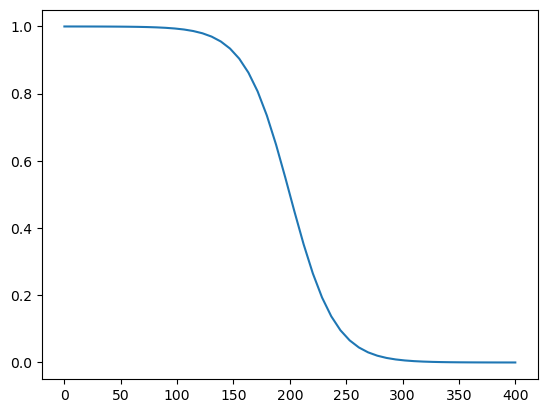

In [5]:
def one_minus_sigmoid( x, x0  ):
    return 1-1/(1 + np.exp(-(x-x0)/(x0/10)))

x_arr = np.linspace( 0, 400 )
plt.plot( x_arr, one_minus_sigmoid(x_arr,200)  )

In [6]:
def train_agent( agent, num_epochs, batch_size, eps_min, eps_max, name, verbose=True ):
    #-- num_epochs: how many batches agent should be trained from 
    #-- batch_size: how many episodes in one batch. [hre I took epoch=batch] 
    #-- eps_max: the maximum rate of exploration = initally, how often we choose a random action
    #-- eps_min: the minimum rate of exploration = at the end, how often we choose a random action
    #-- name: a filename for when we want to save the weights of the network
    
    env = gym.make('CartPole-v1')
    env.reset()
    
    print_array=np.linspace( 0, 0.95, 10 )  #-- just an array to print progress
    pointer = 0  #-- array pointer to keep track of next print event

    t2=-1
    t1=time.time()

    sum_of_rewards_history = []
    best_return = -1
    for jj in range(num_epochs):

        batch_sum_of_rewards = []   #-- keep sum of rewards to keep track of training
        for ii in range( batch_size ):

            #-- temporary memory arrays
            sequence_obsvs = []
            sequence_acts = []
            sequence_rwds = []

            env.reset()
            terminated = False
            truncated = False
            while (not terminated) and (not truncated):   #-- stop the episode when inclination if too much
                
                #-- EXPLORATION: sometimes need to forcefully try other choices to avoid overfitting
                eps = (eps_max-eps_min)*one_minus_sigmoid( jj, num_epochs/2 ) + eps_min
                if np.random.random() < eps:
                    #-- explore
                    action = env.action_space.sample()
                else:
                    #-- use the neural net to generate a policy and choose randomly from it
                    action = agent.choose_action( env.state )

                #-- evolve_system
                obs, reward, terminated, truncated, info = env.step( action )

                #-- store the event in temporary memory arrays
                sequence_obsvs.append( obs )
                sequence_acts.append( action )
                sequence_rwds.append( reward )

            #-- store the temporary memory arrays in the agent's memory
            agent.store_episode( sequence_obsvs, sequence_acts, sequence_rwds )
            batch_sum_of_rewards.append( np.sum( sequence_rwds ) ) 

        #-- monitor the mean sum of rewards. If it outperforms previous steps,
        #-- save the weights so as to remember the best agent
        sum_of_rewards_history.append( np.mean( batch_sum_of_rewards ) )
        if (sum_of_rewards_history[-1] > best_return):  
            agent.policy_network.save_weights('saved_agents/weights_'+name)
            best_return = sum_of_rewards_history[-1]

        #-- printing progress
        if verbose and ( pointer < len(print_array)) and (jj > print_array[pointer]*num_epochs ) :
            pointer+=1
            t2 = time.time()
            print('-- epoch complete: ',jj, end='   ')
            print('mean sum of rewards=',np.round( np.mean( sum_of_rewards_history[-1] ), 4), ', time=', np.round( t2-t1,2) )
            t1=t2

        #-- use events stored in memory to learn from its mistakes, or good actions.
        agent.learn() 
    
    env.close()
    print('--END. Best return=', best_return)
    return sum_of_rewards_history 

In [ ]:
num_epochs = 10000   #-- epochs to be trained on
batch_size = 512
lr=0.0001   #-- learning rate
gam=0.9   #-- discount rate
eps_max=1  #-- initial exploration rate
eps_min=0.01  #-- final exploration rate
fc=8   #-- size of the first layer of the neural net

#-- define a name to keep track of what parameters where used
name='CartPole_lr='+str(lr)+'_gam='+str(gam)+'_'+str(num_epochs)+'epochs_eps='+str(eps_max)+'_'+str(eps_min)\
                        +'_fc'+str(fc)+'_bs'+str(batch_size)
print('-- name: ', name)

#-- create an isntance of Agent
agent = Agent( alpha=lr, n_actions=2,  gamma=gam, fc=fc )

#-- train the agent
sum_of_rewards_history_ = train_agent( agent, num_epochs, batch_size, eps_min, eps_max, name, verbose=True )
plt.plot(sum_of_rewards_history_)

-- name:  CartPole_lr=0.0001_gam=0.9_10000epochs_eps=1_0.01_fc8_bs512
-- epoch complete:  1   mean sum of rewards= 22.7637 , time= 0.96
-- epoch complete:  1056   mean sum of rewards= 23.1523 , time= 925.02
-- epoch complete:  2112   mean sum of rewards= 22.4219 , time= 961.42
-- epoch complete:  3167   mean sum of rewards= 22.2754 , time= 1021.91
-- epoch complete:  4223   mean sum of rewards= 21.6523 , time= 1462.82
-- epoch complete:  5278   mean sum of rewards= 12.1914 , time= 2650.48


In [23]:
#-- load the agent that had yeilded best rewards during training
best_agent = Agent( alpha=lr, n_actions=2,  gamma=gam, fc=fc )
best_agent.policy_network.load_weights('saved_agents/weights_'+name)

In [ ]:
#--  let us now observe the behavior of our best trained agent.
filename = 'videos/best_agent_'+name+'.mp4'
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
video = VideoRecorder(env,filename)
rewards = []
for i in range(100):
    env.render()
    video.capture_frame()
    action = best_agent.choose_action( env.state )
    obs, reward, terminated, truncated, info = env.step( action )
    rewards.append(reward)

print('-- Total obtained reward =', np.sum(rewards))
video.close()
env.close()